In [164]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import time
import pickle


In [165]:
Pi = np.pi
n = 64
L = 8.5 * np.pi
eps = 0.2
phiBar = 0.2
phiAmp = phiBar * 2
dx = L / n
dt = 0.1
tStart = 0
tEnd = 100



In [166]:
# Number of time step
mTotal = int(np.ceil((tEnd - tStart) / dt)) + 1

# Recalculate tEnd in case the specified value is not consistent with mTotal
tEnd = tStart + (mTotal - 1) * dt

print(f"Total time steps: {mTotal}")
print(f"Time: {tStart} -> {tEnd}")

# Calculate array of time steps and time
mArray = np.arange(0, mTotal)
tArray = np.linspace(tStart, tEnd, mTotal)


Total time steps: 1001
Time: 0 -> 100.0


In [167]:
mPlotSkip = 20
mSaveSkip = 1


0.2


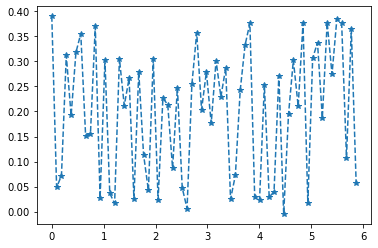

In [168]:
# Calculate X and phi
x = np.linspace(0, 2 * Pi - dx, n)

# Make sure that the average is phi_bar
phi = np.random.random(n)
# width = int(np.floor(n * 0.4))
# left = int(n / 2 - width)
# right = int(n / 2 + width)
# phi[left:right] = 0
phiAve = np.sum(phi) / n
phi = (phi - phiAve) * phiAmp + phiBar

print(np.sum(phi) / n)

plt.figure()
plt.plot(x, phi, "*--")


In [169]:
def live_plot(x, y, figsize=(13, 5), title="", ylim=[-1, 1]):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    plt.plot(x, np.real(y), "*-")
    plt.title(title)
    plt.ylim(ylim)
    plt.grid(True)
    plt.show()
    plt.pause(0.05)


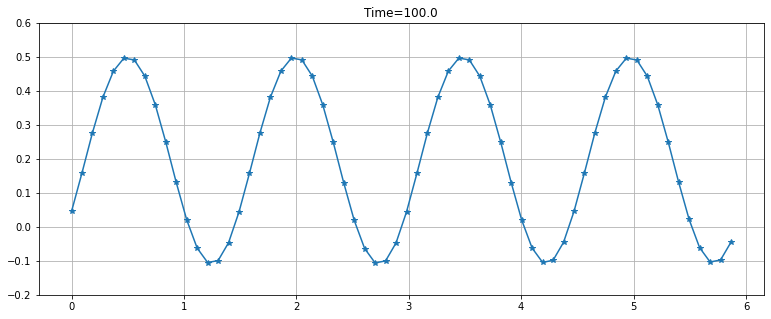

In [170]:
%matplotlib inline

phiOld = phi
ylim = [-0.2, 0.6]
k = 2 * Pi / L * np.concatenate((np.arange(0, n / 2), np.arange(-n / 2, 0)))  # or np.fft.fftfreq(100, d=dx/L)
k2 = np.power(k, 2)
k4 = np.power(k, 4)
k6 = np.power(k, 6)

# Storing data
data = np.zeros((n,mTotal))
for m in mArray:
    t = tArray[m]
    phiOldHat = np.fft.fft(phiOld)
    phiCubeOldHat = np.fft.fft(np.power(phiOld,3))
    numerator = -dt * k2 * phiCubeOldHat + phiOldHat 
    denominator = 1 + dt * (1 - eps) * k2 - 2 * dt * k4 + dt * k6
    phiNewHat = np.divide(numerator , denominator)
    phiNew = np.fft.ifft(phiNewHat)
    phiOld = np.real(phiNew)

    data[:,m] = phiOld

    if np.mod(m, mPlotSkip) == 0:
        live_plot(x, phiOld, title=f'Time={t}', ylim=ylim)

In [171]:
# from matplotlib import cm
# fig, ax = plt.subplots(figsize=(10,10),subplot_kw={"projection": "3d"})
# X, Y = np.meshgrid(x, tArray)
# surf = ax.plot_surface(X, Y, np.transpose(data), cmap=cm.coolwarm, linewidth=0, antialiased=False)



In [182]:
mArraySam = np.floor(np.linspace(0, mTotal-1, 5)).astype(np.int)
tArraySam = tArray[mArraySam]

for m in mArraySam:
    plt.figure(figsize=(5,10))
    plt.plot(x, np.real(y), "*-")
    plt.ylim(ylim)
    plt.grid(True)
    plt.show()
    plt.pause(0.05)

NameError: name 'y' is not defined

<Figure size 360x720 with 0 Axes>

In [172]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Surface(z=np.transpose(data), x=x, y=mArray)])

fig.update_layout(
    title="Density Profile",
    scene=dict(
        xaxis_title="X",
        yaxis_title="Time",
        zaxis_title="Atomic Density",
        aspectmode="manual",
        aspectratio=dict(x=2, y=1, z=1),
    ),
    autosize=False,
    height=800,
    width=800,
    margin=dict(l=65, r=50, b=65, t=90),
)

fig.show()

